In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import imageio
import numpy as np
from tqdm import tqdm

import sys
sys.path.append("../")
from model import NeRF, PositionalEncoding
from rendering import render_full_image
from dataset import LegoDataset
import imageio.v3 as iio

In [4]:
history_path = "../logs/val_images/training_history.npy"

history = np.load(history_path, allow_pickle=True).item()

epochs = history["epoch"]
train_loss = history["train_loss"]
val_loss = history["val_loss"]
train_psnr = history["train_psnr"]
val_psnr = history["val_psnr"]
train_ssim = history.get("train_ssim", [])
val_ssim = history.get("val_ssim", [])
lr = history["lr"]

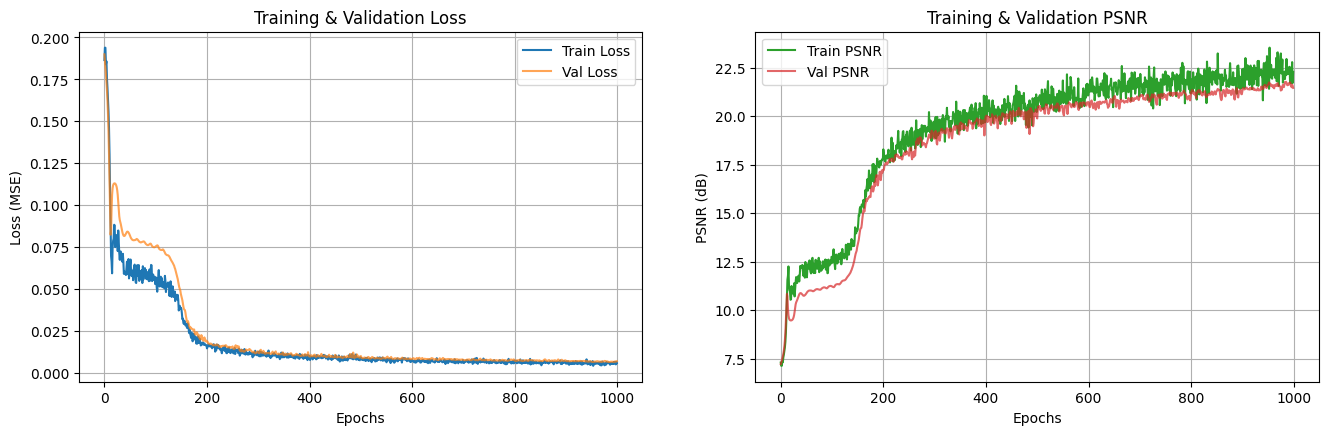

In [7]:
# -- Plotting --
plt.figure(figsize=(16, 10))

# 1. Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", color="tab:blue")
plt.plot(epochs, val_loss, label="Val Loss", color="tab:orange", alpha=0.7)
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# 2. PSNR
plt.subplot(2, 2, 2)
plt.plot(epochs, train_psnr, label="Train PSNR", color="tab:green")
plt.plot(epochs, val_psnr, label="Val PSNR", color="tab:red", alpha=0.7)
plt.xlabel("Epochs")
plt.ylabel("PSNR (dB)")
plt.title("Training & Validation PSNR")
plt.legend()
plt.grid(True)

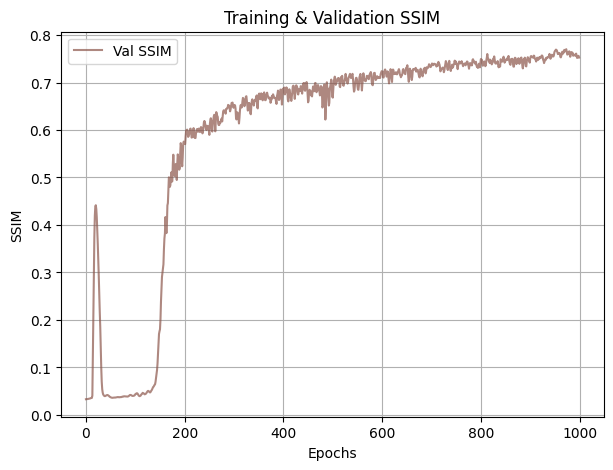

In [10]:
plt.figure(figsize=(7, 5))
plt.plot(epochs, val_ssim, label="Val SSIM", color="tab:brown", alpha=0.7)
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.title("Training & Validation SSIM")
plt.legend()
plt.grid(True)

In [ ]:
val_dir = os.path.join("../", "logs", "val_images", "val_images")

iterations = [200 * k for k in range(1, 6)]  # [200, 400, 600, 800, 1000]
images = []

for i in iterations:
    img_path = os.path.join(val_dir, f"iter_{i-1:06d}.png")
    if os.path.exists(img_path):
        img = iio.imread(img_path)
        images.append((i, img))
    else:
        print(f"Image not found for iteration {i}: {img_path}")

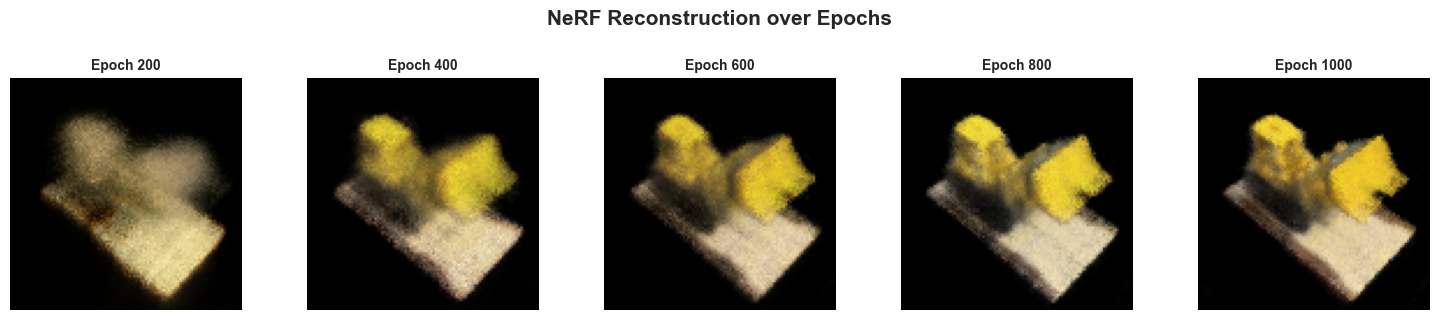

In [16]:
if len(images) > 0:
    plt.style.use("seaborn-v0_8-white")
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))

    for ax, (it, img) in zip(axes, images):
        ax.imshow(img)
        ax.set_title(f"Epoch {it}", fontsize=10, fontweight='semibold')
        ax.axis("off")

    fig.suptitle("NeRF Reconstruction over Epochs", fontsize=15, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()
else:
    print("No images loaded.")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = "../data/tiny_nerf_data.npz"
model_path = "../logs/val_images/model_trained.pth"
output_video = "../outputs/nerf_360.mp4"

n_frames = 120
phi = -30.0   
radius = 4.0
near, far = 2.0, 6.0
n_samples = 64
white_bkgd = False


# === POSE SPHERIQUE ===
def get_translation_matrix(t):
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1]
    ])

def get_rotation_matrix_phi(phi):
    phi = np.deg2rad(phi)
    return np.array([
        [1, 0, 0, 0],
        [0, np.cos(phi), -np.sin(phi), 0],
        [0, np.sin(phi), np.cos(phi), 0],
        [0, 0, 0, 1]
    ])

def get_rotation_matrix_theta(theta):
    theta = np.deg2rad(theta)
    return np.array([
        [np.cos(theta), 0, -np.sin(theta), 0],
        [0, 1, 0, 0],
        [np.sin(theta), 0, np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

def pose_spherical(theta, phi, radius):
    c2w = get_translation_matrix(radius)
    c2w = get_rotation_matrix_phi(phi) @ c2w
    c2w = get_rotation_matrix_theta(theta) @ c2w
    c2w = np.array([
        [-1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]
    ]) @ c2w
    return c2w


# === LOAD DATA AND MODEL ===
dataset = LegoDataset(data_path, split="val")
H, W, focal = dataset.H, dataset.W, dataset.focal

pos_encoder = PositionalEncoding(num_freqs=10)
dir_encoder = PositionalEncoding(num_freqs=4, input_dims=3)

model = NeRF(pos_encoder.output_dims, dir_encoder.output_dims).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"Model loaded from {model_path}")
frames = []

# === GENERATE FRAMES ===
for theta in tqdm(np.linspace(0, 360, n_frames, endpoint=False)):
    c2w = pose_spherical(theta, phi, radius)
    with torch.no_grad():
        img = render_full_image(
            model=model,
            encoder_input=pos_encoder,
            encoder_dir=dir_encoder,
            H=H,
            W=W,
            focal=focal,
            c2w=torch.tensor(c2w, dtype=torch.float32, device=device),
            near=near,
            far=far,
            n_samples=n_samples,
            white_bkgd=white_bkgd,
            device=device,
        )
    frame = (img.cpu().numpy() * 255).astype(np.uint8)
    frames.append(frame)
    print(f"Rendered θ={theta:.1f}°")

# === EXPORT VIDEO ===
imageio.mimsave(output_video, frames, fps=30)
print(f"360° video saved at {output_video}")


Model loaded from ../logs/val_images/model_trained.pth


  1%|          | 1/120 [00:00<01:56,  1.02it/s]

Rendered θ=0.0°


  2%|▏         | 2/120 [00:01<01:46,  1.11it/s]

Rendered θ=3.0°


  2%|▎         | 3/120 [00:02<01:49,  1.07it/s]

Rendered θ=6.0°


  3%|▎         | 4/120 [00:03<01:42,  1.13it/s]

Rendered θ=9.0°


  4%|▍         | 5/120 [00:04<01:38,  1.16it/s]

Rendered θ=12.0°


  5%|▌         | 6/120 [00:05<01:36,  1.19it/s]

Rendered θ=15.0°


  6%|▌         | 7/120 [00:06<01:34,  1.20it/s]

Rendered θ=18.0°


  7%|▋         | 8/120 [00:06<01:32,  1.21it/s]

Rendered θ=21.0°


  8%|▊         | 9/120 [00:07<01:32,  1.20it/s]

Rendered θ=24.0°


  8%|▊         | 10/120 [00:08<01:30,  1.21it/s]

Rendered θ=27.0°


  9%|▉         | 11/120 [00:09<01:29,  1.22it/s]

Rendered θ=30.0°


 10%|█         | 12/120 [00:10<01:42,  1.05it/s]

Rendered θ=33.0°


 11%|█         | 13/120 [00:11<01:41,  1.06it/s]

Rendered θ=36.0°


 12%|█▏        | 14/120 [00:12<01:36,  1.10it/s]

Rendered θ=39.0°


 12%|█▎        | 15/120 [00:13<01:32,  1.14it/s]

Rendered θ=42.0°


 13%|█▎        | 16/120 [00:13<01:29,  1.17it/s]

Rendered θ=45.0°


 14%|█▍        | 17/120 [00:14<01:29,  1.15it/s]

Rendered θ=48.0°


 15%|█▌        | 18/120 [00:15<01:29,  1.13it/s]

Rendered θ=51.0°


 16%|█▌        | 19/120 [00:16<01:31,  1.10it/s]

Rendered θ=54.0°


 17%|█▋        | 20/120 [00:17<01:29,  1.12it/s]

Rendered θ=57.0°


 18%|█▊        | 21/120 [00:18<01:30,  1.10it/s]

Rendered θ=60.0°


 18%|█▊        | 22/120 [00:19<01:28,  1.11it/s]

Rendered θ=63.0°


 19%|█▉        | 23/120 [00:20<01:26,  1.12it/s]

Rendered θ=66.0°


 20%|██        | 24/120 [00:21<01:23,  1.15it/s]

Rendered θ=69.0°


 21%|██        | 25/120 [00:21<01:20,  1.18it/s]

Rendered θ=72.0°


 22%|██▏       | 26/120 [00:22<01:20,  1.17it/s]

Rendered θ=75.0°


 22%|██▎       | 27/120 [00:23<01:18,  1.18it/s]

Rendered θ=78.0°


 23%|██▎       | 28/120 [00:24<01:17,  1.19it/s]

Rendered θ=81.0°


 24%|██▍       | 29/120 [00:25<01:16,  1.19it/s]

Rendered θ=84.0°


 25%|██▌       | 30/120 [00:26<01:15,  1.19it/s]

Rendered θ=87.0°


 26%|██▌       | 31/120 [00:26<01:13,  1.22it/s]

Rendered θ=90.0°


 27%|██▋       | 32/120 [00:27<01:13,  1.20it/s]

Rendered θ=93.0°


 28%|██▊       | 33/120 [00:28<01:13,  1.18it/s]

Rendered θ=96.0°


 28%|██▊       | 34/120 [00:29<01:11,  1.20it/s]

Rendered θ=99.0°


 29%|██▉       | 35/120 [00:30<01:10,  1.21it/s]

Rendered θ=102.0°


 30%|███       | 36/120 [00:31<01:09,  1.20it/s]

Rendered θ=105.0°


 31%|███       | 37/120 [00:31<01:09,  1.19it/s]

Rendered θ=108.0°


 32%|███▏      | 38/120 [00:32<01:08,  1.19it/s]

Rendered θ=111.0°


 32%|███▎      | 39/120 [00:33<01:07,  1.19it/s]

Rendered θ=114.0°


 33%|███▎      | 40/120 [00:34<01:06,  1.20it/s]

Rendered θ=117.0°


 34%|███▍      | 41/120 [00:35<01:07,  1.16it/s]

Rendered θ=120.0°


 35%|███▌      | 42/120 [00:36<01:06,  1.18it/s]

Rendered θ=123.0°


 36%|███▌      | 43/120 [00:36<01:04,  1.20it/s]

Rendered θ=126.0°


 37%|███▋      | 44/120 [00:37<01:03,  1.19it/s]

Rendered θ=129.0°


 38%|███▊      | 45/120 [00:38<01:02,  1.21it/s]

Rendered θ=132.0°


 38%|███▊      | 46/120 [00:39<01:01,  1.21it/s]

Rendered θ=135.0°


 39%|███▉      | 47/120 [00:40<01:00,  1.21it/s]

Rendered θ=138.0°


 40%|████      | 48/120 [00:41<00:59,  1.22it/s]

Rendered θ=141.0°


 41%|████      | 49/120 [00:41<00:58,  1.22it/s]

Rendered θ=144.0°


 42%|████▏     | 50/120 [00:42<00:57,  1.23it/s]

Rendered θ=147.0°


 42%|████▎     | 51/120 [00:43<00:56,  1.23it/s]

Rendered θ=150.0°


 43%|████▎     | 52/120 [00:44<00:55,  1.23it/s]

Rendered θ=153.0°


 44%|████▍     | 53/120 [00:45<00:54,  1.23it/s]

Rendered θ=156.0°


 45%|████▌     | 54/120 [00:45<00:53,  1.23it/s]

Rendered θ=159.0°


 46%|████▌     | 55/120 [00:46<00:53,  1.22it/s]

Rendered θ=162.0°


 47%|████▋     | 56/120 [00:47<00:52,  1.22it/s]

Rendered θ=165.0°


 48%|████▊     | 57/120 [00:48<00:51,  1.22it/s]

Rendered θ=168.0°


 48%|████▊     | 58/120 [00:49<00:50,  1.23it/s]

Rendered θ=171.0°


 49%|████▉     | 59/120 [00:50<00:49,  1.23it/s]

Rendered θ=174.0°


 50%|█████     | 60/120 [00:50<00:48,  1.23it/s]

Rendered θ=177.0°


 51%|█████     | 61/120 [00:51<00:48,  1.22it/s]

Rendered θ=180.0°


 52%|█████▏    | 62/120 [00:52<00:47,  1.22it/s]

Rendered θ=183.0°


 52%|█████▎    | 63/120 [00:53<00:46,  1.23it/s]

Rendered θ=186.0°


 53%|█████▎    | 64/120 [00:54<00:45,  1.23it/s]

Rendered θ=189.0°


 54%|█████▍    | 65/120 [00:54<00:44,  1.23it/s]

Rendered θ=192.0°


 55%|█████▌    | 66/120 [00:55<00:43,  1.23it/s]

Rendered θ=195.0°


 56%|█████▌    | 67/120 [00:56<00:43,  1.23it/s]

Rendered θ=198.0°


 57%|█████▋    | 68/120 [00:57<00:42,  1.23it/s]

Rendered θ=201.0°


 57%|█████▊    | 69/120 [00:58<00:41,  1.23it/s]

Rendered θ=204.0°


 58%|█████▊    | 70/120 [00:59<00:40,  1.23it/s]

Rendered θ=207.0°


 59%|█████▉    | 71/120 [00:59<00:39,  1.23it/s]

Rendered θ=210.0°


 60%|██████    | 72/120 [01:00<00:39,  1.22it/s]

Rendered θ=213.0°


 61%|██████    | 73/120 [01:01<00:38,  1.22it/s]

Rendered θ=216.0°


 62%|██████▏   | 74/120 [01:02<00:37,  1.22it/s]

Rendered θ=219.0°


 62%|██████▎   | 75/120 [01:03<00:36,  1.22it/s]

Rendered θ=222.0°


 63%|██████▎   | 76/120 [01:03<00:35,  1.23it/s]

Rendered θ=225.0°


 64%|██████▍   | 77/120 [01:04<00:35,  1.23it/s]

Rendered θ=228.0°


 65%|██████▌   | 78/120 [01:05<00:34,  1.23it/s]

Rendered θ=231.0°


 66%|██████▌   | 79/120 [01:06<00:33,  1.23it/s]

Rendered θ=234.0°


 67%|██████▋   | 80/120 [01:07<00:32,  1.23it/s]

Rendered θ=237.0°


 68%|██████▊   | 81/120 [01:07<00:31,  1.23it/s]

Rendered θ=240.0°


 68%|██████▊   | 82/120 [01:08<00:31,  1.22it/s]

Rendered θ=243.0°


 69%|██████▉   | 83/120 [01:09<00:30,  1.22it/s]

Rendered θ=246.0°


 70%|███████   | 84/120 [01:10<00:29,  1.22it/s]

Rendered θ=249.0°


 71%|███████   | 85/120 [01:11<00:28,  1.23it/s]

Rendered θ=252.0°


 72%|███████▏  | 86/120 [01:12<00:27,  1.23it/s]

Rendered θ=255.0°


 72%|███████▎  | 87/120 [01:12<00:26,  1.23it/s]

Rendered θ=258.0°


 73%|███████▎  | 88/120 [01:13<00:26,  1.23it/s]

Rendered θ=261.0°


 74%|███████▍  | 89/120 [01:14<00:25,  1.23it/s]

Rendered θ=264.0°


 75%|███████▌  | 90/120 [01:15<00:24,  1.23it/s]

Rendered θ=267.0°


 76%|███████▌  | 91/120 [01:16<00:23,  1.23it/s]

Rendered θ=270.0°


 77%|███████▋  | 92/120 [01:16<00:22,  1.23it/s]

Rendered θ=273.0°


 78%|███████▊  | 93/120 [01:17<00:22,  1.22it/s]

Rendered θ=276.0°


 78%|███████▊  | 94/120 [01:18<00:21,  1.22it/s]

Rendered θ=279.0°


 79%|███████▉  | 95/120 [01:19<00:20,  1.23it/s]

Rendered θ=282.0°


 80%|████████  | 96/120 [01:20<00:19,  1.23it/s]

Rendered θ=285.0°


 81%|████████  | 97/120 [01:21<00:18,  1.23it/s]

Rendered θ=288.0°


 82%|████████▏ | 98/120 [01:21<00:17,  1.23it/s]

Rendered θ=291.0°


 82%|████████▎ | 99/120 [01:22<00:17,  1.23it/s]

Rendered θ=294.0°


 83%|████████▎ | 100/120 [01:23<00:16,  1.23it/s]

Rendered θ=297.0°


 84%|████████▍ | 101/120 [01:24<00:15,  1.23it/s]

Rendered θ=300.0°


 85%|████████▌ | 102/120 [01:25<00:14,  1.23it/s]

Rendered θ=303.0°


 86%|████████▌ | 103/120 [01:25<00:13,  1.22it/s]

Rendered θ=306.0°


 87%|████████▋ | 104/120 [01:26<00:13,  1.22it/s]

Rendered θ=309.0°


 88%|████████▊ | 105/120 [01:27<00:12,  1.22it/s]

Rendered θ=312.0°


 88%|████████▊ | 106/120 [01:28<00:11,  1.22it/s]

Rendered θ=315.0°


 89%|████████▉ | 107/120 [01:29<00:10,  1.22it/s]

Rendered θ=318.0°


 90%|█████████ | 108/120 [01:30<00:09,  1.23it/s]

Rendered θ=321.0°


 91%|█████████ | 109/120 [01:30<00:08,  1.22it/s]

Rendered θ=324.0°


 92%|█████████▏| 110/120 [01:31<00:08,  1.22it/s]

Rendered θ=327.0°


 92%|█████████▎| 111/120 [01:32<00:07,  1.23it/s]

Rendered θ=330.0°


 93%|█████████▎| 112/120 [01:33<00:06,  1.23it/s]

Rendered θ=333.0°


 94%|█████████▍| 113/120 [01:34<00:05,  1.21it/s]

Rendered θ=336.0°


 95%|█████████▌| 114/120 [01:34<00:04,  1.22it/s]

Rendered θ=339.0°


 96%|█████████▌| 115/120 [01:35<00:04,  1.22it/s]

Rendered θ=342.0°


 97%|█████████▋| 116/120 [01:36<00:03,  1.22it/s]

Rendered θ=345.0°


 98%|█████████▊| 117/120 [01:37<00:02,  1.23it/s]

Rendered θ=348.0°


 98%|█████████▊| 118/120 [01:38<00:01,  1.23it/s]

Rendered θ=351.0°


 99%|█████████▉| 119/120 [01:39<00:00,  1.23it/s]

Rendered θ=354.0°


100%|██████████| 120/120 [01:39<00:00,  1.20it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Rendered θ=357.0°
360° video saved at ../logs/nerf_360.mp4
